# COMP90051 Workshop 6
## Pytorch Fundamentals + Logistic Regression / Perceptron revisited

[Pytorch](https://pytorch.org/) is a open-source Python library designed for fast matrix computations on CPU/GPU. This includes both standard linear algebra and deep learning-specific operations. It is based on the neural network backend of the [Torch library](http://torch.ch/). A central feature of Pytorch is its use of Automatic on-the-fly differentiation ([Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) to compute derivatives of (almost) all computations involving tensors, so we can make use of gradient-based updates to optimize some objective function. In this wokkshop we will introduce some fundamental operations in Pytorch and reimplement the Perceptron and logistic regression classifiers in Pytorch.

## The Pytorch Computational Model

To begin, let's take a look at the result of the same computation in Tensorflow and Pytorch.

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# Create matrices with entries drawn from the standard normal, and multiply them
x_tf = tf.random.normal(shape=[4,4], seed=90051)
y_tf = tf.random.normal(shape=[4,8], seed=90051)
z_tf = tf.matmul(x_tf,y_tf)

In [3]:
z_tf

<tf.Tensor 'MatMul:0' shape=(4, 8) dtype=float32>

# 🤔
Why isn't this returning the result of our computation? Unlike normal Python, this doesn't return the value of the computation, but a pointer to a node embedded in a graph structure representing this computation. 

Working in Tensorflow requires us to do some metaprogramming - we must first declare the tensors and associated operations then execute the computation at some later stage. This is known as a _static graph_ framework - operations represent _nodes_ while tensors are _edges_ in a computational graph structure. Working 'twice removed' from our results can be confusing, especially in complex models which use conditionals such as `if` and `while`. One must construct a `tf.Session` object to link the pre-built graph to the `C++` runtime.

In [4]:
sess = tf.InteractiveSession()
z_exec = sess.run(z_tf)
sess.close()

In [5]:
z_exec

array([[ 2.8596952 ,  0.3273892 ,  2.873675  ,  0.48469874,  1.2711748 ,
         0.8563199 ,  0.9283391 , -0.42388076],
       [ 1.5722368 , -1.5325701 ,  3.1406956 , -1.2870395 ,  6.0068636 ,
        -0.17227657, -1.193126  , -0.00930476],
       [-0.46073008, -2.2349877 ,  0.68634343, -1.0923438 ,  2.81542   ,
         1.1884441 , -0.98392045,  0.5919136 ],
       [ 1.5563524 ,  3.6226463 , -2.9798799 ,  1.1010416 , -5.380503  ,
         2.405279  ,  3.7010026 ,  1.4303797 ]], dtype=float32)

NB: [Tensorflow 2.0](https://www.tensorflow.org/beta) will be moving away from the static graph framework to support dynamic execution by default.
Let's look at the same operation in Pytorch.

In [6]:
import torch
from torch.utils import data

# Create matrices with entries drawn from the standard normal, and multiply them
x_pt = torch.randn(size=[4,4])
y_pt = torch.randn(size=[4,8])
z_pt = torch.matmul(x_pt, y_pt)

In [7]:
z_pt

tensor([[-0.4845,  1.2619, -0.7200,  2.4036,  0.3987,  0.7568, -2.6314,  0.3387],
        [ 0.2009,  0.4129, -0.4028, -2.2993, -2.0155,  1.7518,  0.1065, -1.4674],
        [ 0.1984, -1.7449,  1.1858, -0.6902,  0.9697, -2.4714,  2.8343,  0.7565],
        [ 0.5373,  0.2477,  0.7199,  1.3376,  2.4788, -0.4375, -0.0554,  1.4291]])

Like regular Python, the result is returned immediately! Behind the scenes, each time we evaluate a Pytorch operation, the library silently defines a new computation graph which is executed immediately, rather than deferred to some later stage. This usually makes debugging easier (but no always!) and supports native Python control flow and iteration. For more discussion of the pros and cons of static vs. dynamic graphs one may refer to https://arxiv.org/abs/1701.03980. 

*Discussion:* Which framework do you think is more efficient?

*Answer:* One big point of contention is the relative speed of both approaches. In modern applications, the network parameters will always remain on the GPU during computation. The network structure can be thought of as metadata that tells the GPU which operations to perform in which order. Generating this metadata dynamically typically incurs a negligible overhead relative to the actual matrix computations.

### Basic Ops

We will not spend much time covering basic operations here. The basic API is extremely similar to `numpy`. One may consult the [excellent introduction at the official Pytorch repository](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). 

* The fundamental object in Pytorch is the Tensor. This is a generalized matrix - essentially an $n$-dimensional table of numerical values. 

In [8]:
x = torch.Tensor([2,7,1,8,2])
print(x**2)

tensor([ 4., 49.,  1., 64.,  4.])


* One may perform the basic mathematical operations expected on Tensors. In future weeks we will see that 3D tensors can be used to represent a sequence of identically sized 2D matrices - or a multichannel image.

In [9]:
x = torch.randn(size=[3,3,3])
for i in range(x.shape[0]):
    print(x[i,:,:])

tensor([[ 0.2774,  0.0398, -1.5757],
        [ 0.6422,  1.3335, -1.7065],
        [-0.6635,  0.8482,  2.1396]])
tensor([[ 0.2518, -0.0986, -0.6423],
        [ 0.3541, -0.0615, -0.4540],
        [ 0.9171, -0.9176,  0.7865]])
tensor([[ 0.0630, -1.1009,  0.4526],
        [-0.0301,  0.4703, -1.3757],
        [ 1.7433,  0.0522,  1.2043]])


* Similarly, 4D tensors can be used to represent a sequence of 3D tensors, or a matrix of identically sized matrices.

In [10]:
x = torch.randn(size=[2,2,2,2])

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i,j,:,:])

tensor([[ 1.3668, -0.1514],
        [ 1.1241, -0.1391]])
tensor([[-0.2171,  0.8176],
        [ 0.6803,  0.6000]])
tensor([[-1.3698, -0.0717],
        [ 1.5275, -0.7417]])
tensor([[-1.0308, -0.1486],
        [-1.2979,  0.1006]])


* We can easily convert between `numpy` arrays and `torch` tensors.

In [11]:
x = np.ones(9)*2
x_pt = torch.from_numpy(x)
print(x)
print(x_pt)

[2. 2. 2. 2. 2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=torch.float64)


In [12]:
x_pt = torch.pow(x_pt,8)
# Create a new 'view' of the same underlying 1D vector of 
# numbers stored in memory - similar to np.reshape
x_pt = x_pt.view([3,3])  
x = x_pt.numpy()
print(x)

[[256. 256. 256.]
 [256. 256. 256.]
 [256. 256. 256.]]


### Autograd
To compute the gradients of tensors with respect to other tensors, a full record of operations performed on the Tensor must be retained. This can be achieved by setting the attribute `.requires_grad = True`. After the computation is finished, calling `.backward()` on the output tensor walks through the computation history in reverse order to automatically compute the gradients using a method based on the chain rule, which can be used for optimization of arbitrary loss functions.

In [13]:
mu = 0
x = torch.ones([3,3], requires_grad=True)
loss = torch.exp(-(x-mu)**2/(2)).mean()
loss.backward()

The gradient for the tensor `x` is accumulated into the `.grad` attribute. We would use this in some gradient based update rule, such as vanilla SGD.

In [14]:
x.grad

tensor([[-0.0674, -0.0674, -0.0674],
        [-0.0674, -0.0674, -0.0674],
        [-0.0674, -0.0674, -0.0674]])

Did we get the gradients right? Using the chain rule to calculate the gradients of the loss $l$ with respect to $x$ analytically, we find:

$$ l = \frac{1}{9} \exp\left[-\frac{(x-\mu)^2}{2}\right] \implies \frac{dl}{dx} = - \frac{1}{9}(x-\mu)\exp\left[-\frac{(x-\mu)^2}{2}\right] \$$

In [15]:
dl_dx = lambda x: - 1/9 * (x-mu) * np.exp(-(x-mu)**2/2)
print(dl_dx(1))

-0.06739229552362594


Ok, so the analytic gradient and the autograd-computed gradient agree - but autograd can be very useful when evaluating the derivatives of loss functions constructed as a sequence of nested operations (an example is the cross-entropy loss when using a neural network for classification) where the analytic derivative is difficult to compute symbolically.

Note that autograd is **not** symbolic or numerical (finite-differences) differentiation, both of which have trouble handling gradients of relatively long nested functions. It is essentially a dynamic-programming approach to symbolic differentiation.

## The Perceptron, reborn

In the remaining part of this workshop we'll look at two different ways of implementing the Perceptron in Pytorch. The first is the conditional approach you encountered last week and the second employs gradient descent on the Perceptron objective function. First we'll generate the data as before:

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import time, os

from sklearn.datasets import make_classification

def create_toy_data(n_samples=250, class_sep=2):
    X, Y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                               n_redundant=0, n_clusters_per_class=1, flip_y=0,
                               class_sep=class_sep, random_state=1)
    Y[Y==0] = -1  # encode "negative" class using -1 rather than 0
    plt.plot(X[Y==-1,0], X[Y==-1,1], ".", label="$y = -1$")
    plt.plot(X[Y==1,0], X[Y==1,1], ".", label="$y = 1$")
    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()
    
    return X.astype(np.float32), Y.astype(np.float32)

def plot_results(X_train, Y_train, X_test, Y_test, score_fn, threshold = 0):
    # Plot training set
    plt.plot(X_train[Y_train==-1,0], X_train[Y_train==-1,1], ".", label=r"$y=-1$, train")
    plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], ".", label=r"$y=1$, train")
    plt.gca().set_prop_cycle(None) # reset colour cycle

    # Plot test set
    plt.plot(X_test[Y_test==-1,0], X_test[Y_test==-1,1], "x", label=r"$y=-1$, test")
    plt.plot(X_test[Y_test==1,0], X_test[Y_test==1,1], "x", label=r"$y=1$, test")

    # Compute axes limits
    border = 1
    x0_lower = X[:,0].min() - border
    x0_upper = X[:,0].max() + border
    x1_lower = X[:,1].min() - border
    x1_upper = X[:,1].max() + border

    # Generate grid over feature space
    resolution = 0.01
    x0, x1 = np.mgrid[x0_lower:x0_upper:resolution, x1_lower:x1_upper:resolution]
    grid = np.c_[x0.ravel(), x1.ravel()]
    s = score_fn(grid).reshape(x0.shape)

    # Plot decision boundary (where s(x) == 0)
    plt.contour(x0, x1, s, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)

    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()
    

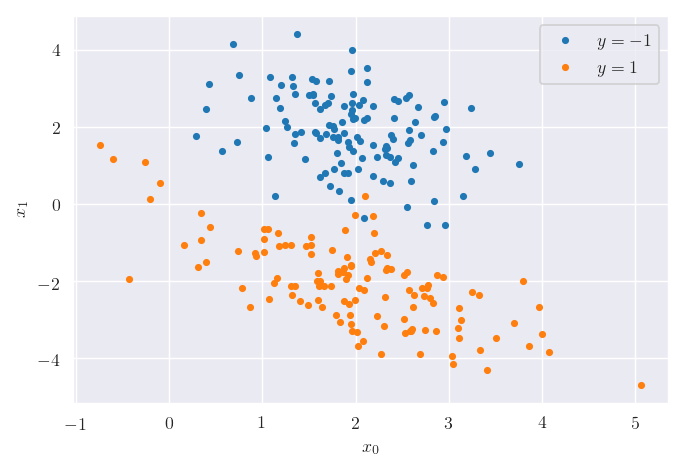

In [17]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
X, Y = create_toy_data(class_sep=2)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))
x_train, y_train = torch.from_numpy(X_train), torch.from_numpy(Y_train)
x_test, y_test = torch.from_numpy(X_test), torch.from_numpy(Y_test)

add_bias_column = lambda x: torch.cat([torch.ones(x.shape[0],1), x], dim=1)

Training set has 167 instances. Test set has 83 instances.


Firstly, we'll re-implement the Perceptron update rule from last week in Torch. To simplify matters, we'll include the bias term in the weight vector and prepend a column of ones to the feature matrix to account for this. 

<img src="https://i.imgur.com/N6NZrAC.png" alt="Perceptron alg." width="750"/>

In [37]:
def train_perceptron(x, y, n_epochs=10, eta=0.1):
    
    x = add_bias_column(x)
    w = torch.zeros(x.shape[1])
    
    for _ in range(n_epochs):
        errors = 0
        for i in range(x.size(0)):
            if torch.dot(x[i],w) * y[i] <= 0:
                deltaW = eta * x[i] * y[i]
                w = w + deltaW
                errors += 1
            
        if errors == 0: break;
            
    print('Errors: {} / {} Iterations'.format(errors, n_epochs*x.shape[0]))
    print('Trained weights:', w)
    return w.numpy()

In [38]:
w = train_perceptron(x_train, y_train)

Errors: 55 / 1670 Iterations
Trained weights: tensor([ 0.9000, -0.3789, -0.7182])


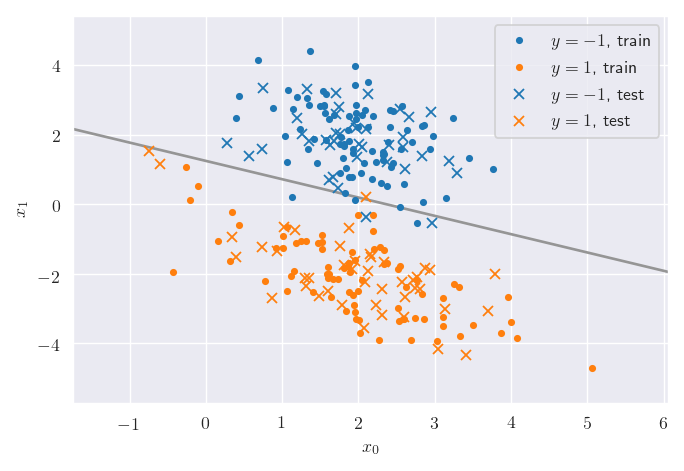

In [21]:
plot_results(X_train, Y_train, X_test, Y_test, score_fn=lambda x: np.dot(x,w[1:])+w[0])

By design, the above update scheme is equivalent to sequential gradient descent on the following objective function:

\begin{align}
    F(\mathbf{w}) &= \frac{1}{T} \sum_{t=1}^T \max\left(0, -y_t (\mathbf{w} \cdot \mathbf{x}_t)\right) \\
    \mathbf{w}_{t+1} &\leftarrow \mathbf{w}_t - \eta \nabla_{\mathbf{w}} F(\mathbf{w}) 
\end{align}

Below we'll use the autograd mechanics of Pytorch to implement this update scheme. The prototypical optimization strategy in Torch is as follows:
1. Define parameters to be optimized (in this case, $\mathbf{w}$)
2. Define an update rule through an `optimizer` (in this case, sequential gradient descent using `torch.optim.SGD`)
3. Start the training loop:
    * Retrieve your input tensors `x`
    * Compute your model output tensors `out` in the forward pass: `out = my_fancy_model(x)`
    * Compute the loss at each iteration. (`loss = my_loss_function(out)`)
    * Find the gradient of the loss with respect to trainable model parameters $\mathbf{w}$ through autograd. (`loss.backward()`)
    * Take a gradient step to minimize the loss (`optimizer.step()`)
    * Reset accumulated gradients to zero for the next iteration (`optimizer.zero_grad()`). This step is needed as Pytorch by default accumulates gradients.

In [22]:
def perceptron_loss(x,y,w):
    """
    Inputs:
        w: Trainable weight vector
           Torch tensor, of shape [n_features]
        x: Feature matrix
           Torch tensor, of shape [batch_size, n_features]
        y: Truth labels
           Torch tensor, of shape [batch_size]
    """
    # Remove trailing '1' dimensions
    x = torch.squeeze(x)
    
    flag = -y * (torch.dot(w,x))
    loss = torch.max(torch.Tensor([0]), flag)
    
    return loss

In [23]:
def train_perceptron_SGD(x, y, n_epochs=10, eta=0.1):
    
    # Create iterable dataset in Torch format - technical details, 
    # don't worry too much about this!
    x = add_bias_column(x)
    train_ds = torch.utils.data.TensorDataset(x, y)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1)
    
    # Create trainable weight vector, tell Torch to track operations on w
    w = torch.zeros(x.shape[1], requires_grad=True)
    
    # Setup the optimizer. This implements the basic gradient descent update
    optimizer = torch.optim.SGD([w], lr=eta)
    
    for _ in range(n_epochs):
        for i, (x,y) in enumerate(train_loader):
            x = torch.squeeze(x)
            
            # Compute loss F(w)
            loss = perceptron_loss(x,y,w)
            
            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next ieration
        
    w = w.detach()  # Tell Torch to stop tracking operations for autograd
    print('Trained weights:', w)
    return w.numpy()

In [24]:
w = train_perceptron_SGD(x_train, y_train)

Trained weights: tensor([ 0.9000, -0.3789, -0.7182])


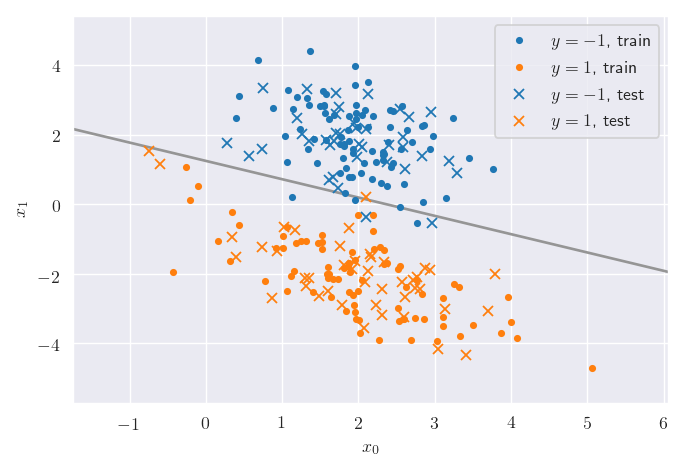

In [25]:
plot_results(X_train, Y_train, X_test, Y_test, score_fn=lambda x: np.dot(x,w[1:])+w[0])

As expected, we get the same results. While there is no discernable advantage here in using autograd mechanics to compute gradient-based updates, we will now take a look at an image classification example where the analytic gradient is intractable. In such situations we must rely on automatic differentiation to compute the gradients of the loss with respect to the model parameters needed for backpropagation.

## Multiclass Logistic Regression

Remember two weeks ago when there was a question on how to generalize binary logistic regression to more than two classes? This is why it pays to do the bonus section. We briefly repeat the argument here, for more details one can refer to the solutions on Blackboard.

We would like to output an $m$-dimensional vector of conditional class probabilities $(p_1, p_2, \ldots, p_m)$. We require $p_k \in [0,1]$ and $\sum_k p_k=1$ by the law of total probability. Taking inspiration from the logistic regression case, we can achieve this by exponentiating the output of our classifier $f(\mathbf{x}) = W^T \mathbf{\Phi}(\mathbf{x}) = \left[\mathbf{w}_0^T\mathbf{\Phi} \vert \ldots \vert \mathbf{w}_m^T\mathbf{\Phi}\right]$, where $\mathbf{\Phi}: \mathbb{R}^d \rightarrow \mathbb{R}^D$ is some possibly nonlinear transformation typically mapping the instance $\mathbf{x} \in \mathbb{R}^d$ to some higher-dimensional space, and $\mathbf{w} \in \mathbb{R}^D$, $W \in \mathbb{R}^{D \times m}$. In essence we have multiple weight vectors $(\mathbf{w}_1, \ldots \mathbf{w}_m)$, one corresponding to each class, and the output $\mathbf{w}_k \cdot \mathbf{\Phi}(\mathbf{x})$ 'scores' how much the classifier thinks the instance $\mathbf{x}$ belongs to class $k$. More concretely, the matrix operation looks like:

\begin{equation}
    W^T \mathbf{\Phi} = \begin{bmatrix}
      \leftarrow \mathbf{w}^{T}_{0} \rightarrow \\
      \leftarrow \mathbf{w}^{T}_{1} \rightarrow \\
      \vdots \\
      \leftarrow \mathbf{w}^{T}_{m} \rightarrow \\ 
    \end{bmatrix}
    \begin{bmatrix}
      \mathbf{\Phi}^{(1)}  \\
      \mathbf{\Phi}^{(2)}  \\
      \vdots \\
      \mathbf{\Phi}^{(D)}
    \end{bmatrix}
    = \begin{bmatrix}
      \mathbf{w}_0 \cdot \mathbf{\Phi}  \\
      \mathbf{w}_1 \cdot \mathbf{\Phi}  \\
      \vdots \\
      \mathbf{w}_m \cdot \mathbf{\Phi}
    \end{bmatrix} \in \mathbb{R}^m
\end{equation}

This will return a vector of length $m$. Each dimension of this vector should correspond to the unnormalized probability $\tilde{p}_k$, commonly referred to as the _logits_. We then require normalization of the probability output, which can be achieved by dividing by $\sum_k \tilde{p}_k$. Hence we have:
\begin{align}
    p(y=k \vert \mathbf{x}) = \frac{\exp\left[\left(\mathbf{w}_k^T \Phi(\mathbf{x})\right)\right]}{\sum_n \exp\left[\left(\mathbf{w}_n^T \Phi(\mathbf{x})\right)\right]}
\end{align}
The process of converting the unnormalized weight-feature dot product(s) to a normalized distribution is called a softmax operation. Since the exponential is monotonic, the class prediction is given by taking the index with the highest conditional probability - i.e. the highest score $\mathbf{w}_k^T \mathbf{\Phi}(\mathbf{x})$. The classifier is trained by minimizing the negative log likelihood, which corresponds to the negative cross entropy loss.

\begin{equation}
    \mathcal{L}(\mathbf{w}) = -\log \prod_k p(y=k \vert \mathbf{x}; \mathbf{w}) = -\sum_k y_k \log p\left(y=k \vert \mathbf{x}; \mathbf{w}\right)
\end{equation}

We'll start by using some convenience functions provided by Torch to download the canonical `MNIST` dataset, transform and load it into Tensor format. MNIST is a multi-class classification data set where the instances $\mathbf{x}$ are images of handwritten digits (28×28 pixels with a single 8-bit channel). Here the target $y_k \in \{0, 1, \ldots, 9\}$. We'll train in batches of multiple elements to exploit vectorization of matrix operations. 

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

In [26]:
import torchvision
import torchvision.transforms as transforms

batch_size = 64

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

We can visualize 8 randomly sampled digits below. 

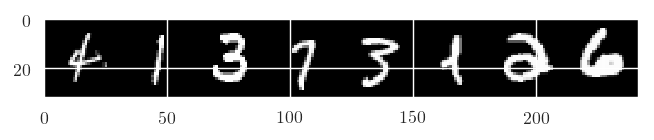

In [27]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]

imshow(torchvision.utils.make_grid(images))

## Defining the model

#### The following sections are especially important! Please ensure you understand every word below, and bother your tutor if anything is unclear!


Let's step through what we need to setup before we can invoke the training loop. The first thing on the agenda is to define our trainable parameters - in this case, the $10$ weight vectors arranged into a `[n_classes, n_features]` matrix and a bias vector of length `n_classes`. We'll use a popular empirically motivated initialization scheme called Xavier/Glorot initialization to use for our initial weight parameters. Note that here we are using each pixel in the image as a feature. This is not the ideal way to process the information contained within a natural image, but we'll stick with it for the sake of simplicity. `MNIST` is so simple that almost any sensible method will yield $<90 \%$ accuracy!

In [28]:
n_classes = 10
n_features = 784
n_epochs = 10
batch_size = 64

# W = torch.zeros([n_features, n_classes], requires_grad=True)
W = torch.nn.init.xavier_uniform_(torch.empty([n_features, n_classes], requires_grad=True))  # Initialize weight vector
b = torch.zeros([n_classes], requires_grad=True)

Remember that the logits (unnormalized probabilities) are defined as the result of the computation $\tilde{p}_k = W^T \mathbf{x} + b$, where $\mathbf{x}$ is the flattened image. This will return a vector of length `n_classes`. Each entry in this vector corresponds to an unnormalized score corresponding to the likelihood of the class index (higher is better).

In [29]:
x = images[0]  # Take a sample iamge
x = x.view(-1)  # Flatten the image
logits = torch.matmul(torch.t(W),x) + b  # Compute logits
print(logits)

tensor([-0.4616, -1.1492,  0.0562, -0.0212, -0.0457,  0.2176,  0.2470, -0.0878,
         0.6458,  0.0275], grad_fn=<AddBackward0>)


Below we define the loss function we will use and construct an optimizer that will update the learnable parameters in our model through some gradient-based update scheme to minimize the loss function. In this case just vanilla SGD with a momentum term. We need to supply all the learnable parameters in our model to the `parameters` argument. This is needed for MLE, as we saw earlier.

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W,b], lr=1e-2) #, momentum=0.9, nesterov=True)

We have defined the learnable parameters, and defined a loss function and optimizer that tells us how to update our parameters to minimize the cross-entropy loss. Now we enter the training loop.

In [31]:
LOG_INTERVAL = 250
running_loss, running_accuracy = list(), list()
start_time = time.time()

for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times
    
    epoch_loss = 0.
    
    for i, data in enumerate(train_loader):  # Loop over elements in training set
        
        x, labels = data
        
        x = x.view(batch_size, -1)  # Flatten images but keep batch dimension
        logits = torch.matmul(x,W) + b  # Compute scores
        
        predictions = torch.argmax(logits, dim=1)
        train_acc = torch.mean(torch.eq(predictions, labels).float()).item()
        
        loss = criterion(input=logits, target=labels)
    
        loss.backward()               # Backward pass (compute parameter gradients)
        optimizer.step()              # Update weight parameter using SGD
        optimizer.zero_grad()         # Reset gradients to zero for next iteration
        
        
        # ============================================================================
        # You can safely ignore the boilerplate code below - just reports metrics over
        # training and test sets

        running_loss.append(loss.item())
        running_accuracy.append(train_acc)
        
        epoch_loss += loss.item()

        if i % LOG_INTERVAL == 0:  # Log training stats
            deltaT = time.time() - start_time
            mean_loss = epoch_loss / (i+1)
            print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                i, len(train_loader), mean_loss, train_acc, deltaT))
        
    print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))
    
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data
        x = x.view(batch_size, -1)  # Flatten images but keep batch dimension
        
        with torch.no_grad():
            logits = torch.matmul(x,W) + b  # Compute scores
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)
            
    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()
    
    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))

[TRAIN] Epoch 0 [0/937]| Mean loss 2.3247 | Train accuracy 0.09375 | Time 0.02 s
[TRAIN] Epoch 0 [250/937]| Mean loss 1.5373 | Train accuracy 0.81250 | Time 7.85 s
[TRAIN] Epoch 0 [500/937]| Mean loss 1.2353 | Train accuracy 0.85938 | Time 15.57 s
[TRAIN] Epoch 0 [750/937]| Mean loss 1.0691 | Train accuracy 0.89062 | Time 23.44 s
Epoch complete! Mean loss: 0.9869
[TEST] Mean loss 0.6062 | Accuracy 0.8594
[TRAIN] Epoch 1 [0/937]| Mean loss 0.6643 | Train accuracy 0.82812 | Time 30.56 s
[TRAIN] Epoch 1 [250/937]| Mean loss 0.5995 | Train accuracy 0.89062 | Time 38.54 s
[TRAIN] Epoch 1 [500/937]| Mean loss 0.5826 | Train accuracy 0.89062 | Time 46.47 s
[TRAIN] Epoch 1 [750/937]| Mean loss 0.5661 | Train accuracy 0.73438 | Time 54.32 s
Epoch complete! Mean loss: 0.5548
[TEST] Mean loss 0.4802 | Accuracy 0.8796
[TRAIN] Epoch 2 [0/937]| Mean loss 0.4058 | Train accuracy 0.90625 | Time 61.64 s
[TRAIN] Epoch 2 [250/937]| Mean loss 0.4890 | Train accuracy 0.82812 | Time 69.49 s
[TRAIN] Epoch 2 

You should be getting $>90/\%$ train accuracy with similar test accuracy within a minute on CPU _(note to tutors - check on your machine?)_, not bad for a _linear method_! 😎 Finally, let's plot the loss and accuracy curves. You may want to fiddle with the learning rate when your loss stats to plateau.

In [32]:
from scipy.signal import savgol_filter  # Smooth spiky curves
running_loss_smoothed = savgol_filter(running_loss, 21, 3)
running_acc_smoothed = savgol_filter(running_accuracy, 21, 3)

Text(0,0.5,'Cross-entropy Loss (Train)')

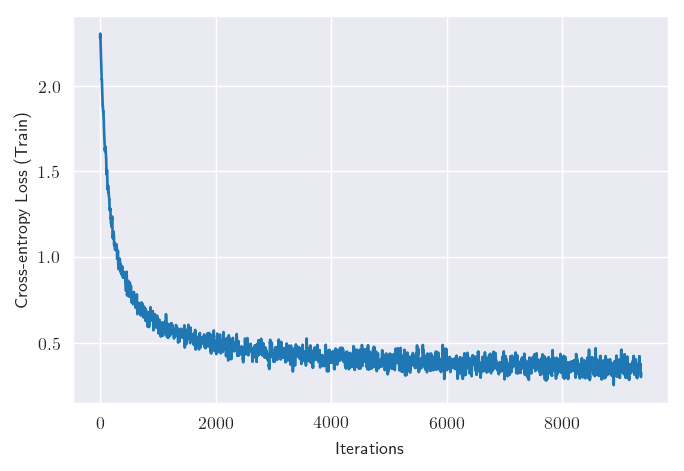

In [33]:
plt.plot(running_loss_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss (Train)')

(0.2, 1.0)

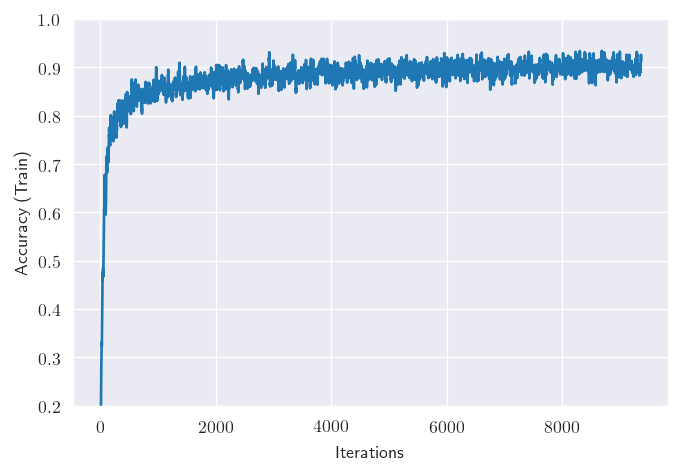

In [34]:
plt.plot(running_acc_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (Train)')
plt.ylim(0.2,1.)

**Bonus:** Can you improve on this? You may want to try building a multilayer Perceptron, changing the optimizer, experimenting with learning rates or momentum, or building a convolutional NN architecture. Some quick modifications should allow you to surpass 98% accuracy pretty easily.

That's all for this week. Next week we'll be looking at best practices and more complicated workloads in Pytorch, particularly how to use the canoncial `torch.nn.Module` class to streamline your work.